In [1]:
import jax.numpy as np
import pandas as pd
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive, init_to_median
from numpyro.diagnostics import hpdi, print_summary
from plotnine import *
# import plotnine
numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)
rng_key = random.PRNGKey(0)
theme_set( theme_seaborn(style='darkgrid'))
# plotnine.options.set_option('figure_size',(12,8))
%config InlineBackend.figure_format ='retina'

## Homework Week2

https://github.com/rmcelreath/statrethinking_winter2019/blob/master/homework/week02.pdf


### Question 1

>The weights listed below were recorded in the !Kung census, but heights were not recorded for the weights 45, 40, 65, 31 and 53. Provide predicted heights and 89% compatibility intervals for each of these individuals. That is, fill in the table below, using model-based predictions.

>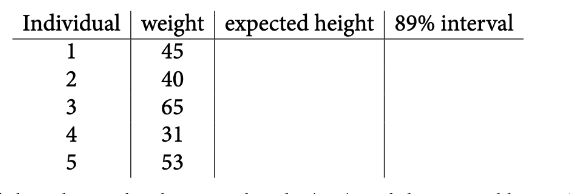

So the way I see this question is basically build a model and then use posterior to make predictions. 

    height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041914  41.0     1
4  145.415  41.276872  51.0     0


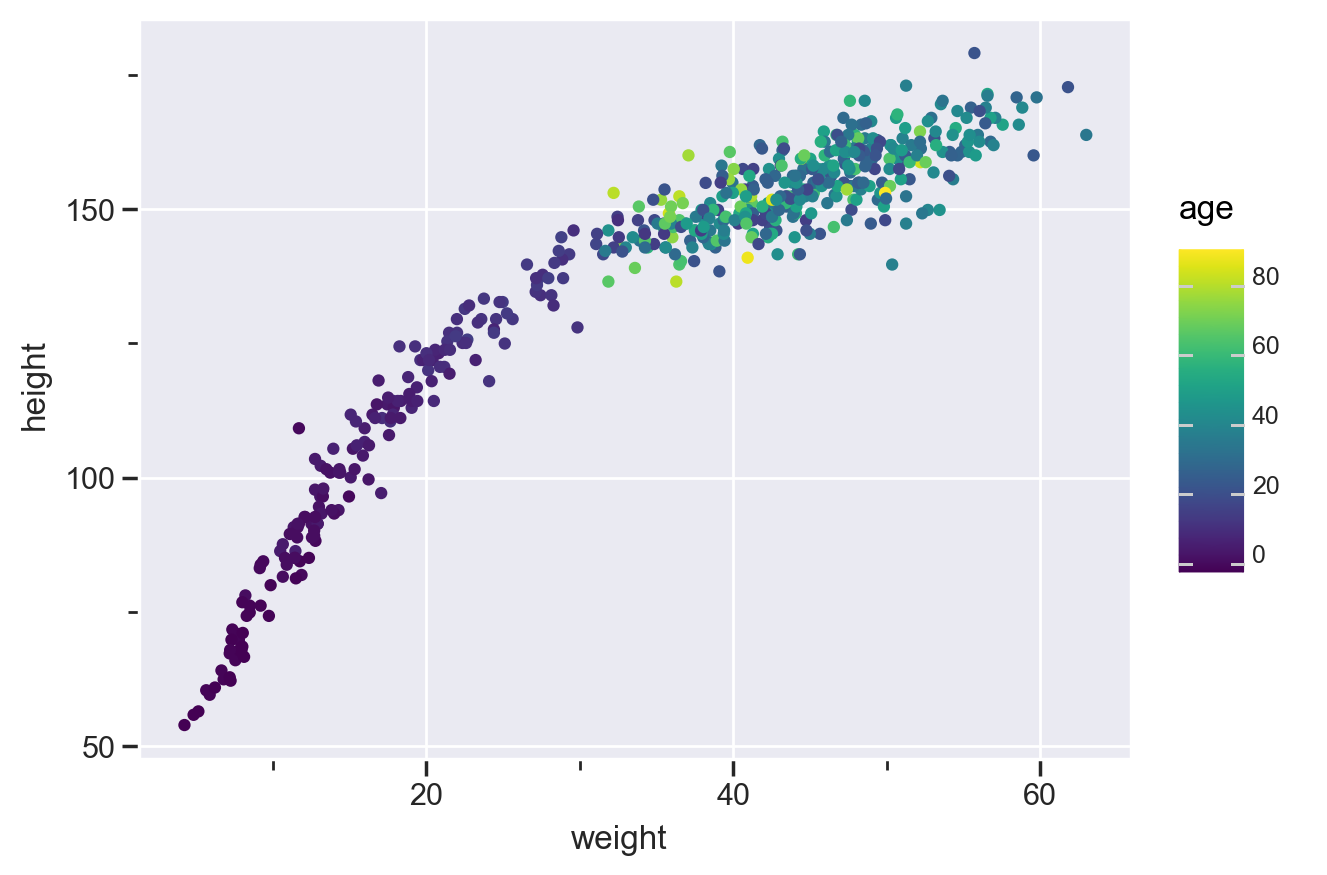

<ggplot: (8780683179168)>

In [2]:
df_data = pd.read_csv("../data/Howell1.csv",sep=";")
print(df_data.head())
(
    ggplot(df_data,aes(x='weight', y='height', color='age')) +
    geom_point() 
)

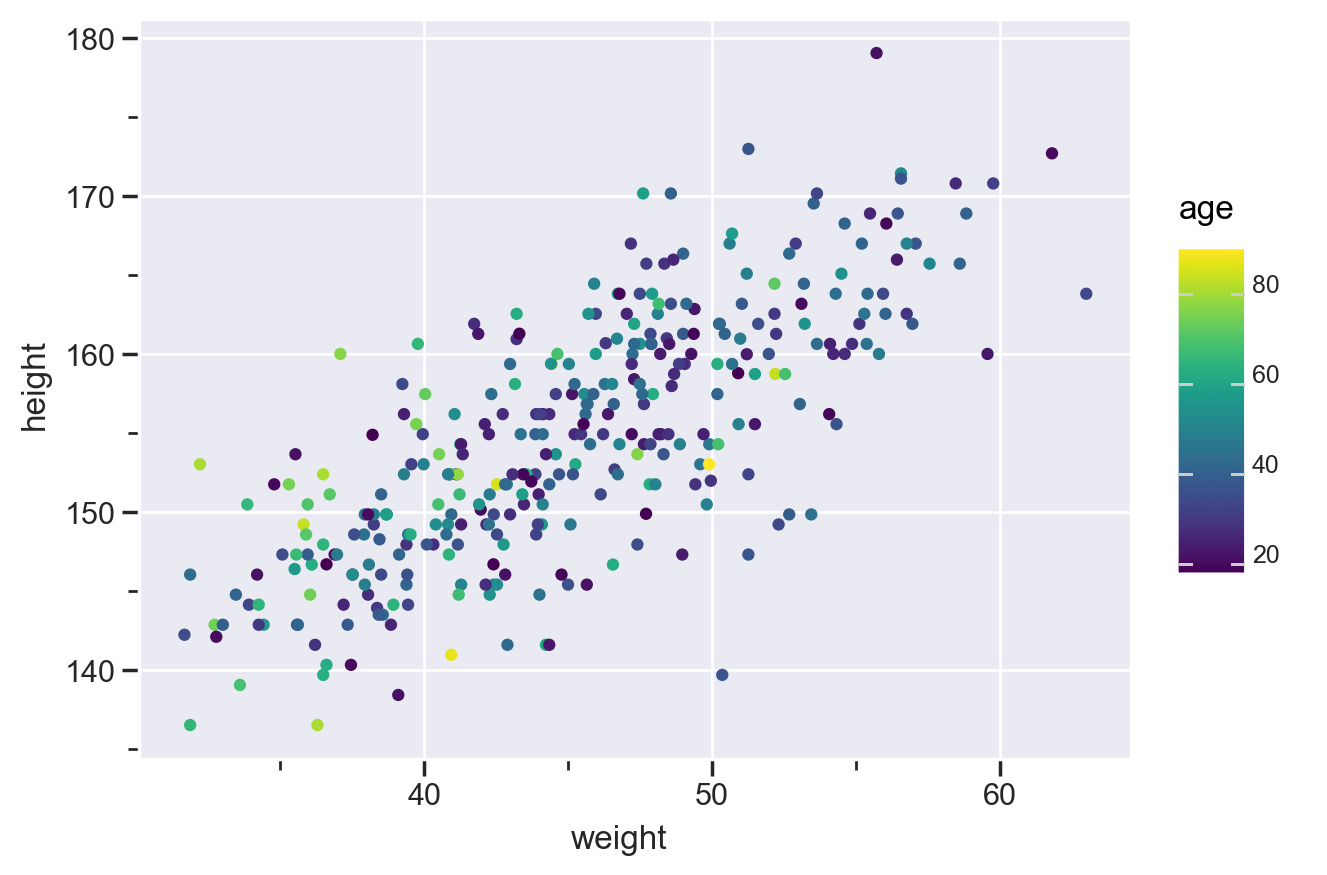

<ggplot: (8780683793439)>

In [3]:
df_adult_data = df_data[df_data.age>=20]
(
    ggplot(df_adult_data,aes(x='weight', y='height', color='age')) +
    geom_point() 
)

In [4]:
def model(weight, height=None):
    # priors
    alpha = numpyro.sample('alpha', dist.Normal(178,20))
    beta = numpyro.sample('beta', dist.Normal(0,10))
    sigma = numpyro.sample('sigma', dist.Uniform(0,50))
    # likelihood
    mu = numpyro.deterministic('mu', alpha + beta*weight)
    numpyro.sample('height_hat', dist.Normal(mu,sigma), obs=height)

**Will sort this later that progress bar is not working**

In [5]:
# kernel = NUTS(model)
# mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4,chain_method='parallel')
# mcmc.run(rng_key, weight=df_adult_data.weight.values, height=df_adult_data.height.values)
# mcmc.print_summary()

In [6]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4,chain_method='parallel', progress_bar=False)
mcmc.run(rng_key, weight=df_adult_data.weight.values, height=df_adult_data.height.values)
posterior = mcmc.get_samples()
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha    114.27      1.96    114.24    110.98    117.26    562.11      1.00
      beta      0.90      0.04      0.90      0.83      0.96    571.57      1.00
     sigma      5.12      0.20      5.11      4.78      5.44    838.92      1.00

Number of divergences: 0


**Now to get the predictions we can just use predictive and pass it new values at which we need predictions. The steps are as follows:***

* get posterior
* call predictive with that posterior and pass values you want to get predictions for


I will first do it for the trained values to see how well we do there and then will do it for new values. 



/Users/smishra/anaconda3/envs/statrethinking/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


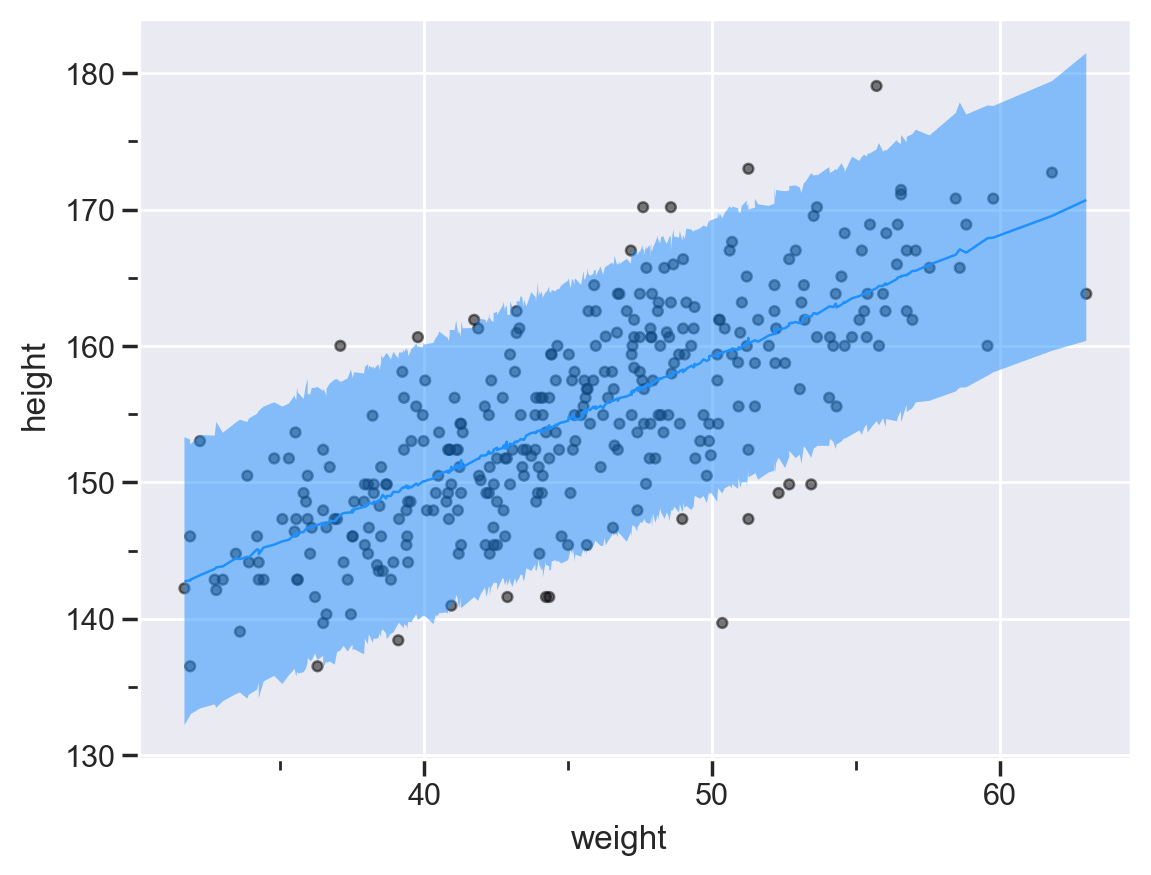

<ggplot: (8780727676188)>

In [18]:
predictions = Predictive(model, posterior)(rng_key, weight=df_adult_data.weight.values)
df_adult_data['expected height'] = np.mean(predictions['height_hat'],axis=0)
pred_hpdi = np.percentile(predictions['height_hat'], q=(2.5, 97.5), axis=0)
df_adult_data['lower'] = pred_hpdi[0]
df_adult_data['higher'] = pred_hpdi[1]
(
    ggplot(df_adult_data,aes(x='weight', y='height')) +
    geom_point(alpha=0.5) +
    geom_line(aes(y='expected height'),color='dodgerblue') +
    geom_ribbon(aes(y='expected height',ymin='lower',ymax='higher'), fill='dodgerblue', alpha=0.5)+
    theme_seaborn(style='darkgrid')
)

Now doing predictions for new points

In [8]:
weights = np.array([45,40,65,31,53])
predictions = Predictive(model, posterior)(rng_key, weight=weights)
df_pred = pd.DataFrame([(hpdi(s,prob=0.89),np.mean(s)) for s in predictions['height_hat']._value.T])
df_pred['Weight'] = weights
df_pred.rename(columns={0:'89% CI', 1:'Expected Height'},inplace=True)
df_pred = df_pred.reindex(columns=['Weight','Expected Height', '89% CI'])
df_pred

,Weight,Expected Height,89% CI
0,45,154.75041,"[146.38252, 163.12863]"
1,40,150.12358,"[141.90924, 158.06009]"
2,65,172.69609,"[164.18382, 180.50352]"
3,31,142.0235,"[134.01947, 150.71152]"
4,53,161.75546,"[153.86491, 170.52148]"


### Question 2

>Model the relationship between height (cm) and the natural logarithm of weight (log-kg): log(weight). Use the entire Howell1 data frame, all 544 rows, adults and non-adults. Use any model type from Chapter 4 (from the book) that you think useful: an ordinary linear regression, a polynomial or a spline. Plot the posterior predictions against the raw data

    height     weight   age  male  log weight
0  151.765  47.825606  63.0     1    3.867561
1  139.700  36.485807  63.0     0    3.596923
2  136.525  31.864838  65.0     0    3.461503
3  156.845  53.041914  41.0     1    3.971082
4  145.415  41.276872  51.0     0    3.720302


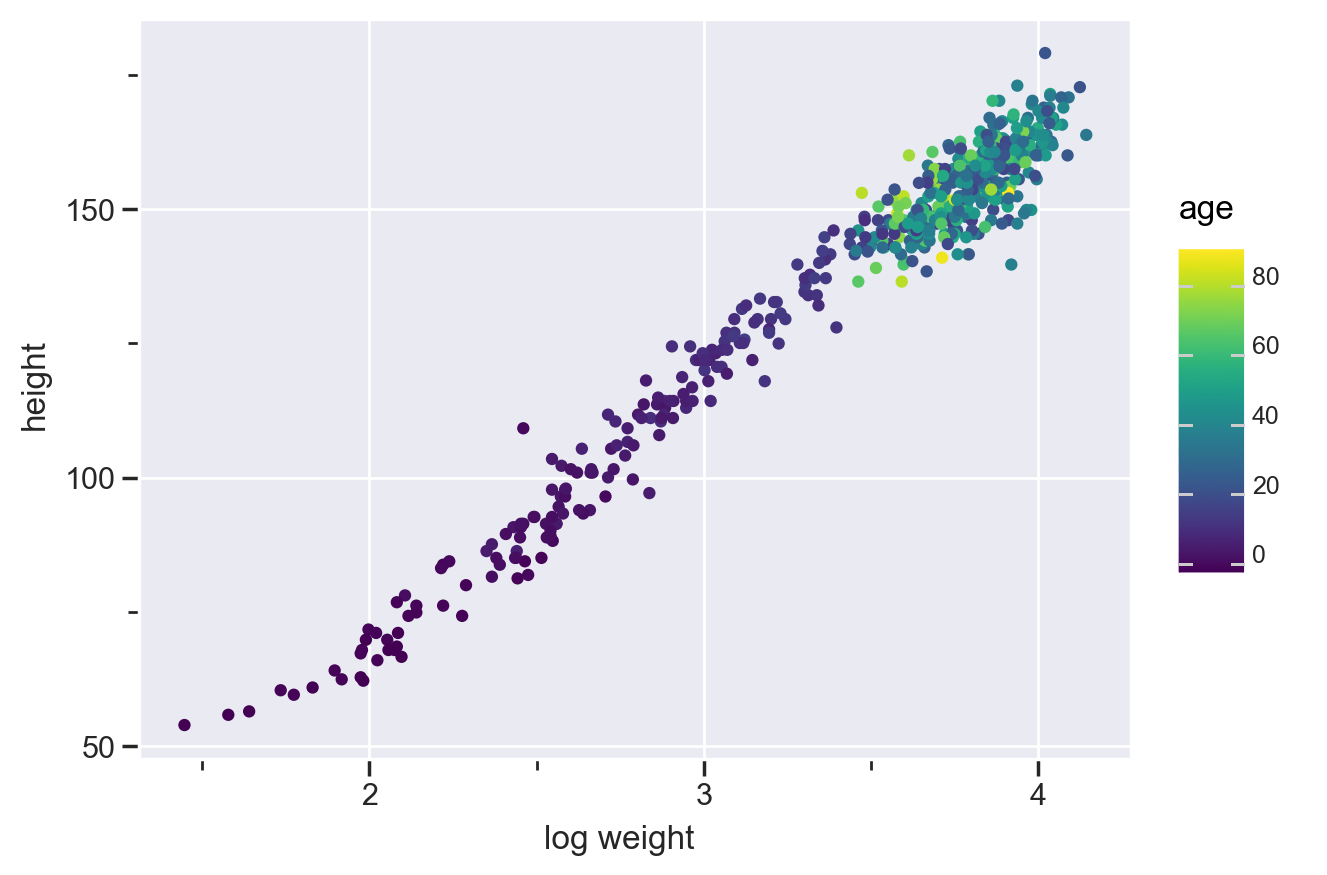

<ggplot: (8780674842561)>

In [9]:
df_data['log weight'] = np.log(df_data.weight.values)
print(df_data.head())
(
    ggplot(df_data,aes(x='log weight', y='height', color='age')) +
    geom_point() +
    theme_seaborn(style='darkgrid')
)

Will first try a linear model (why not!!)

In [51]:
def run_inference_lr(model=None, weight=None, height=None,num_warmup=500, num_samples=1000, num_chains=4,chain_method='parallel', progress_bar=False, b_sigma=10):
    if(model==None):
        print("No model passed")
        return None
    else:
        kernel = NUTS(model, init_strategy=init_to_median)
        mcmc = MCMC(kernel, 
                    num_warmup=num_warmup, 
                    num_samples=num_samples, 
                    num_chains=num_chains, 
                    chain_method=chain_method, 
                    progress_bar=False)
        mcmc.run(rng_key, 
                 weight=weight, 
                 height=height,
                 b_sigma=b_sigma)
        mcmc.print_summary()
        posterior = mcmc.get_samples()
        return(posterior, mcmc)

def get_posterior_pred_lr(model = None, posterior = None,  weight = None, data  = None, b_sigma=10):
    if(model==None):
        print("No model passed")
        return None
    else:
        predictions = Predictive(model, posterior)(rng_key, weight=weight, b_sigma = b_sigma)
        data['expected height'] = np.mean(predictions['height_hat'],axis=0)
        pred_hpdi = np.percentile( predictions['height_hat'], q=(2.5, 97.5), axis=0)
        data['lower'] = pred_hpdi[0]
        data['higher'] = pred_hpdi[1]
        return (predictions,data)
    
def model_lr(weight, height=None,b_sigma=10):
    # priors
    alpha = numpyro.sample('alpha', dist.Normal(178,20))
    beta = numpyro.sample('beta', dist.Normal(0,b_sigma))
    sigma = numpyro.sample('sigma', dist.Uniform(0,50))
    # likelihood
    mu = numpyro.deterministic('mu', alpha + beta*weight)
    numpyro.sample('height_hat', dist.Normal(mu,sigma), obs=height)    

In [52]:
def plot_pred_interval(data):
    p = (
        ggplot(data,aes(x='weight', y='height')) +
        geom_point(alpha=0.5) +
        geom_line(aes(y='expected height'),color='dodgerblue') +
        geom_ribbon(aes(ymin='lower',ymax='higher'), fill='dodgerblue', alpha=0.3) 
    )
    return p

In [53]:
df_lr_10 = df_data
df_lr_10_w = df_data
df_lr_1 = df_data
df_poly = df_data


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha    -22.64      1.30    -22.67    -24.79    -20.52   1393.57      1.00
      beta     46.75      0.37     46.76     46.13     47.36   1379.92      1.00
     sigma      5.16      0.16      5.15      4.91      5.43   1801.59      1.00

Number of divergences: 0


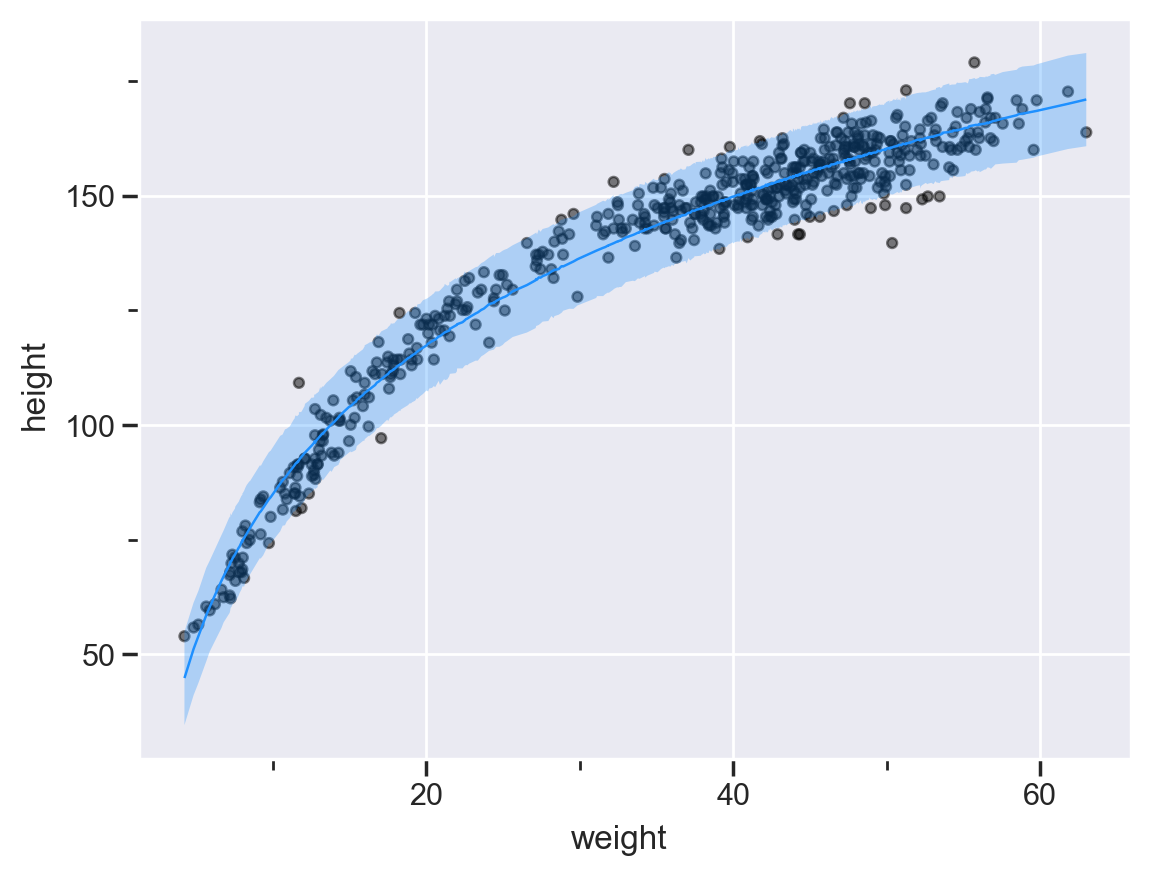

<ggplot: (8780698651058)>

In [54]:
posterior_lr_10,mcmc_lr_10 = run_inference_lr(model_lr, weight = df_lr_10['log weight'].values, height = df_lr_10.height.values, b_sigma=10)
plot_pred_interval(get_posterior_pred_lr(model = model_lr,posterior=posterior_lr_10,weight=df_lr_10['log weight'].values,data=df_lr_10,b_sigma=10)[1])


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     87.67      4.36     87.71     80.21     94.39    831.24      1.00
      beta     14.75      1.24     14.74     12.59     16.67    811.25      1.00
     sigma     19.37      0.91     19.34     17.92     20.86    899.13      1.00

Number of divergences: 0


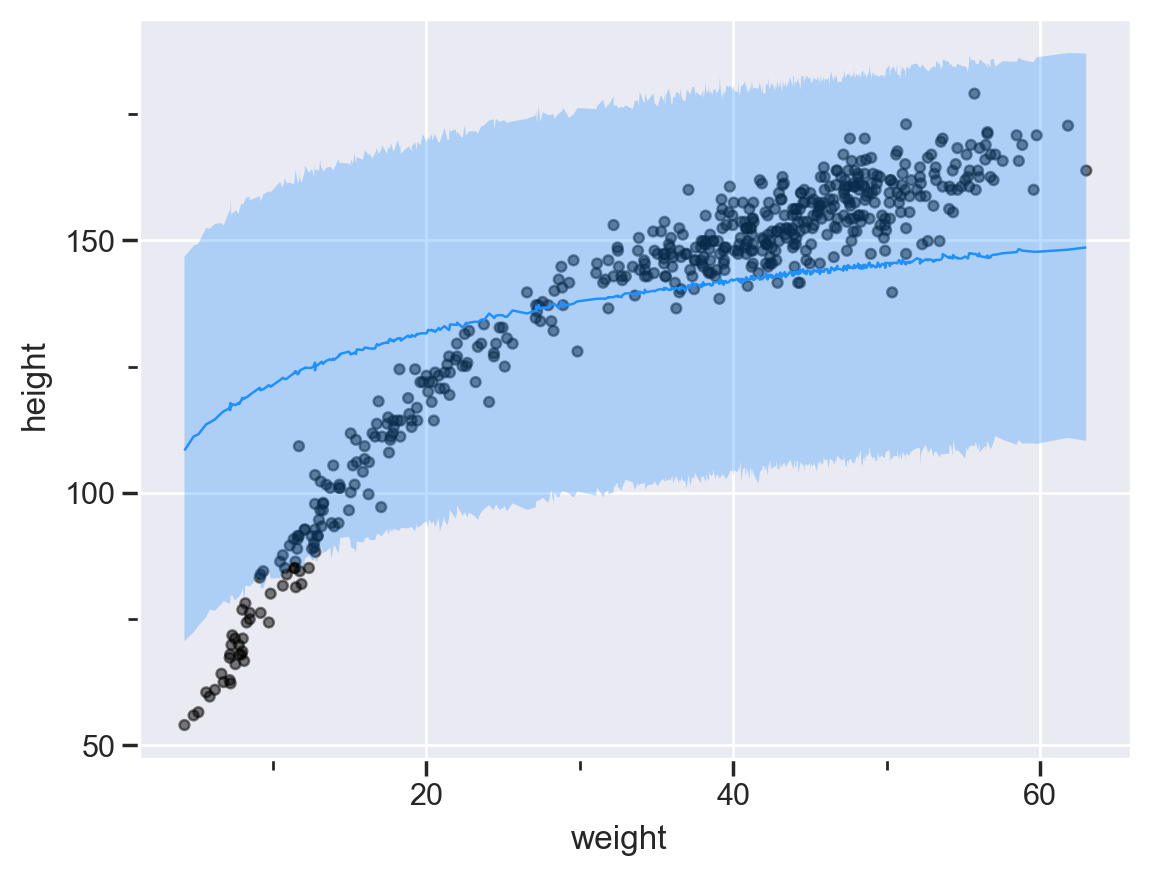

<ggplot: (8780778338829)>

In [55]:
posterior_lr_1,mcmc_lr_1 = run_inference_lr(model_lr, weight = df_lr_1['log weight'].values, height = df_lr_1.height.values, b_sigma=1)
plot_pred_interval(get_posterior_pred_lr(model = model_lr,posterior=posterior_lr_1,weight=df_lr_1['log weight'].values,data=df_lr_1,b_sigma=1)[1])


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     75.75      1.04     75.75     74.04     77.45   1627.39      1.00
      beta      1.76      0.03      1.76      1.71      1.80   1631.17      1.00
     sigma      9.38      0.29      9.37      8.92      9.86   2043.62      1.00

Number of divergences: 0


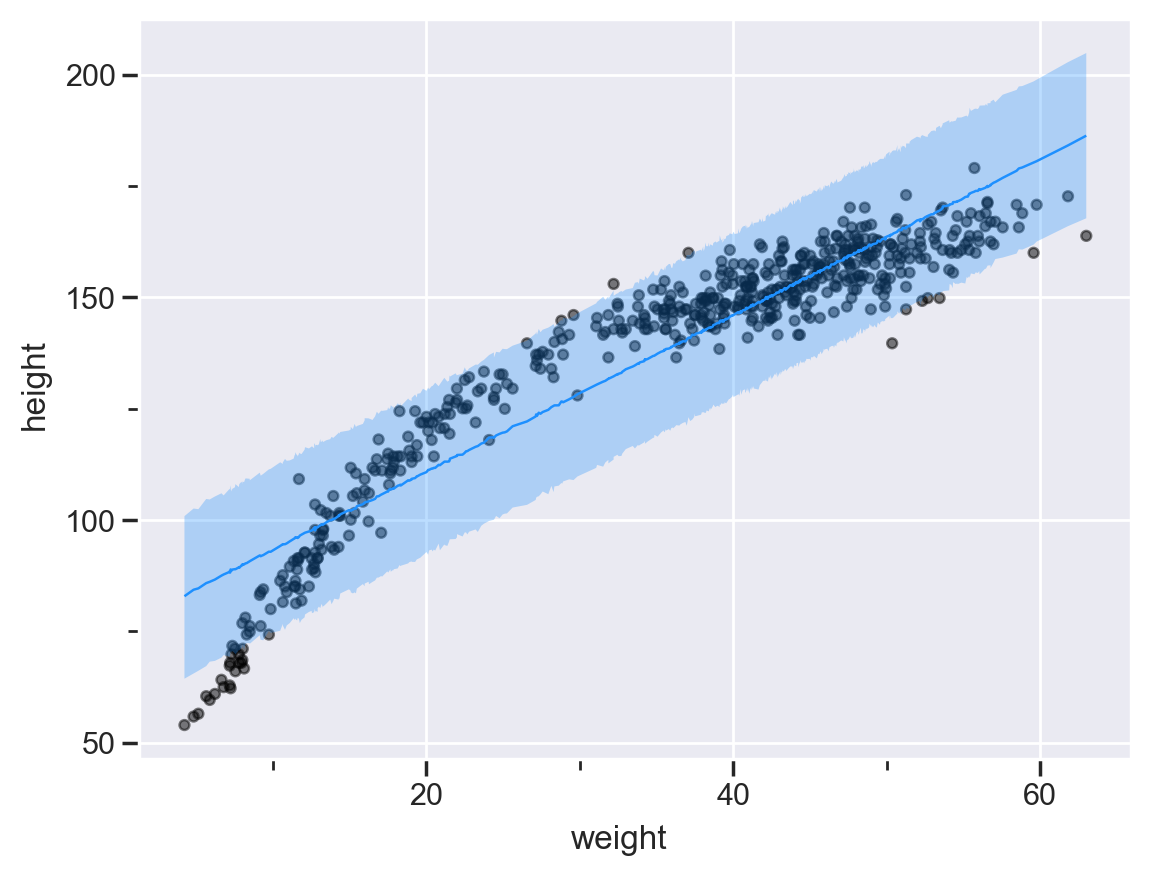

<ggplot: (8780730153000)>

In [56]:
# ## Just for fun again model with weight not log(weight) but for all of the data; this is not part of the question
# posterior_lr_10_w,mcmc_lr_10_w = run_inference_lr(model_lr, weight = df_lr_10_w['weight'].values, height = df_lr_10_w.height.values, b_sigma=10)
# plot_pred_interval(get_posterior_pred_lr(model = model_lr,posterior=posterior_lr_10_w,weight=df_lr_10_w['weight'].values,data=df_lr_10_w,b_sigma=10)[1])

**Here actually linear fit is decent to work with if you give beta enough freedom to move, i.e., $\beta\sim\mathcal{N}(0,10)$; but with  $\beta\sim\mathcal{N}(0,1)$ results are bad. However intutuively I will not like to have $\alpha$ as negative (in case of log(wt) it is height of human with weight 1kg). Therefore lets see how we do with a polynomial model**

In [57]:
def model_poly(weight, height=None,b_sigma=10):
    # priors
    alpha = numpyro.sample('alpha', dist.Normal(178,20))
    beta1 = numpyro.sample('beta1', dist.Normal(0,b_sigma))
    beta2 = numpyro.sample('beta2', dist.Normal(0,b_sigma))
    sigma = numpyro.sample('sigma', dist.Uniform(0,50))
    # likelihood
    mu = numpyro.deterministic('mu', alpha + beta1*weight + beta2 * (weight**2))
    numpyro.sample('height_hat', dist.Normal(mu,sigma), obs=height)    


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha    -19.63      5.81    -19.56    -28.94    -10.29    505.90      1.01
     beta1     44.66      3.87     44.59     38.41     50.84    464.24      1.01
     beta2      0.34      0.62      0.35     -0.68      1.36    457.03      1.01
     sigma      5.18      0.17      5.18      4.93      5.49   1189.68      1.01

Number of divergences: 0


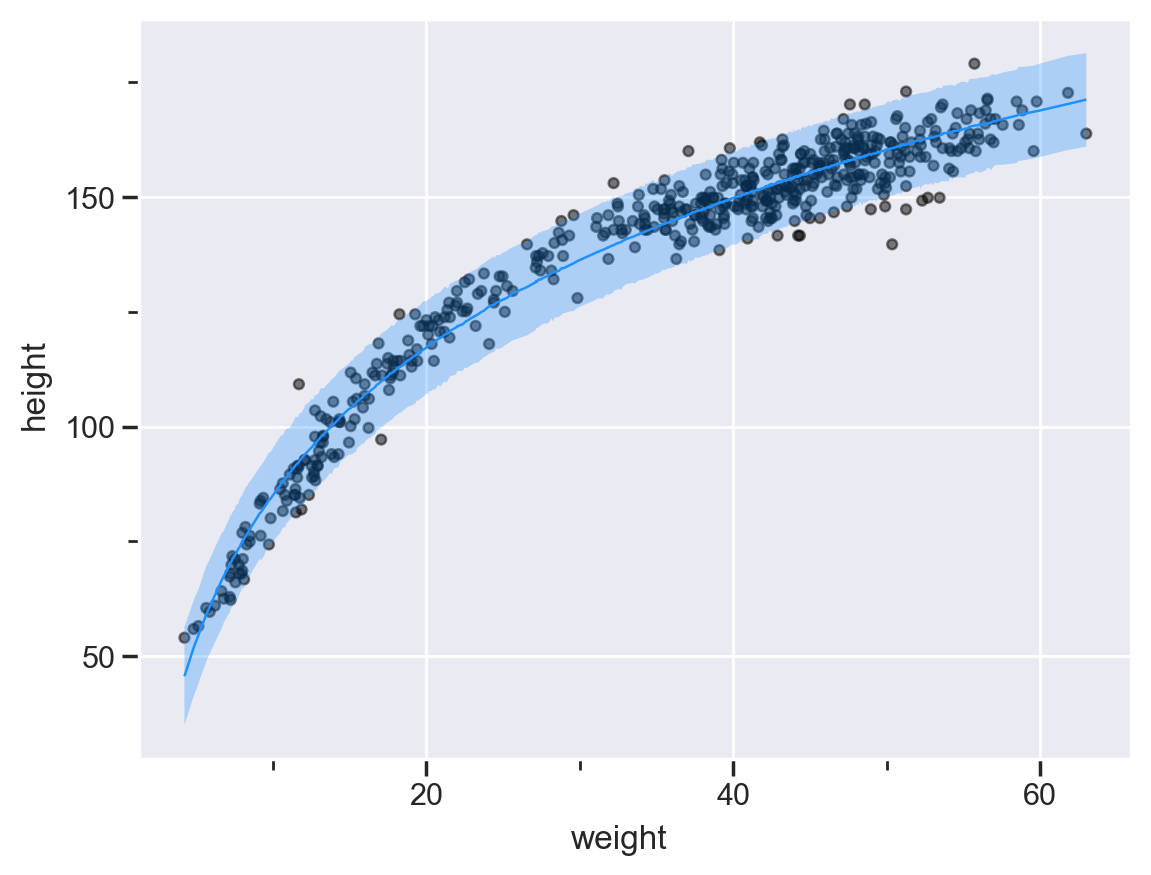

<ggplot: (8780780474317)>

In [58]:
posterior_poly_10,mcmc_poly_10 = run_inference_lr(model_poly, weight = df_poly['log weight'].values, height = df_poly.height.values, b_sigma=10)
plot_pred_interval(get_posterior_pred_lr(model = model_poly,posterior=posterior_poly_10,weight=df_poly['log weight'].values,data=df_poly,b_sigma=10)[1])


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     42.43      1.72     42.47     39.50     45.12   1101.84      1.00
     beta1      3.23      0.98      3.22      1.59      4.73   1077.66      1.00
     beta2      6.96      0.18      6.96      6.68      7.24   1323.71      1.00
     sigma      6.06      0.19      6.06      5.74      6.35   1657.59      1.00

Number of divergences: 0


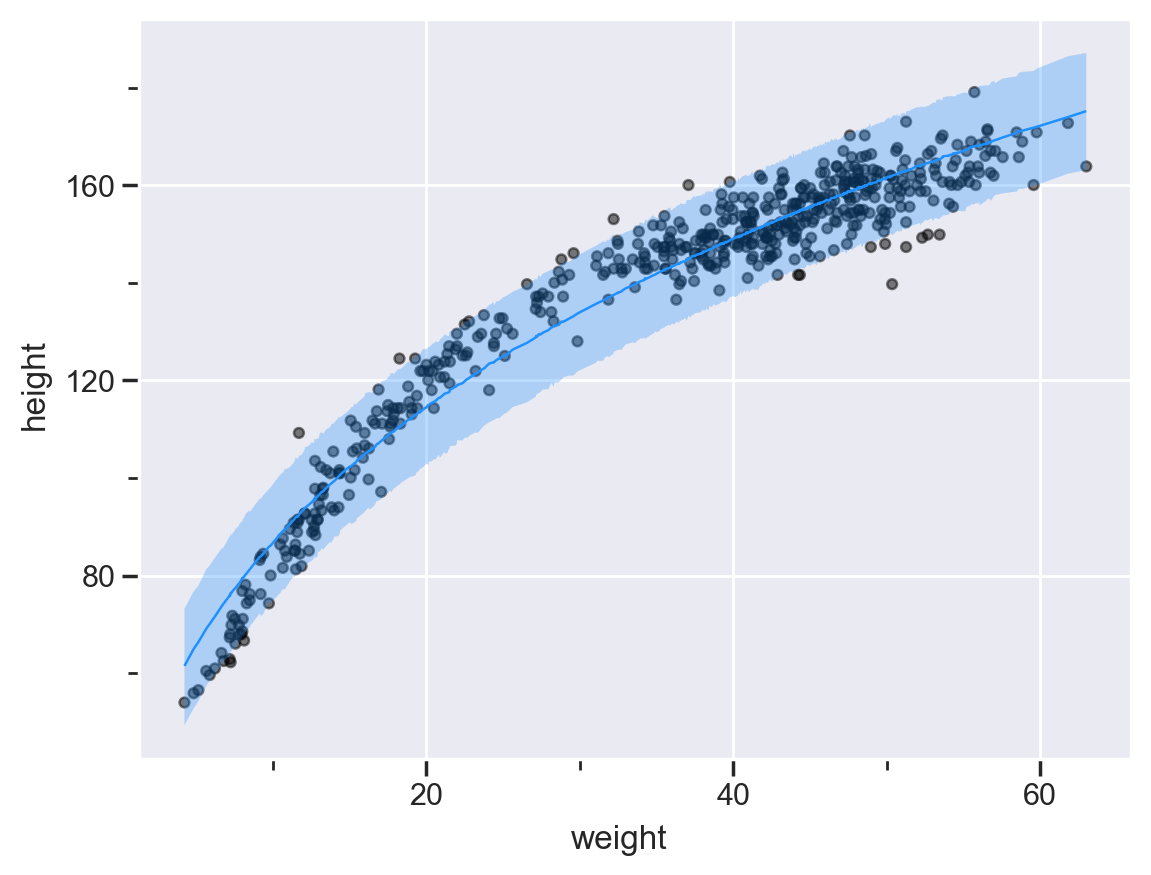

<ggplot: (8780688576290)>

In [59]:
posterior_poly_1,mcmc_poly_1 = run_inference_lr(model_poly, weight = df_poly['log weight'].values, height = df_poly.height.values, b_sigma=1)
plot_pred_interval(get_posterior_pred_lr(model = model_poly,posterior=posterior_poly_1,weight=df_poly['log weight'].values,data=df_poly,b_sigma=1)[1])

Here both fits are good. However if you give $\beta$ a very loose prior, i.e.,  $\beta\sim\mathcal{N}(0,10)$, $\alpha$ is still neagtive ; but with  $\beta\sim\mathcal{N}(0,1)$  results are good and every thing intutively makes sense.

### Question 3

>Plot the prior predictive distribution for the polynomial regression model in Chapter 4 (just what we did in the previous exercise). You can modify the the code that plots the linear regression prior predictive distribution. 20 or 30 parabolas from the prior should suffice to show where the prior probability resides. Can you modify the prior distributions of $\alpha$, $\beta_1$, and $\beta_2$ so that the prior predictions stay within the biologically reasonable outcome space? That is to say: Do not try to fit the data by hand. But do try to keep the curves consistent with what you know about height and weight, before seeing these exact data